In [117]:
import pandas as pd
import numpy as np
#import sweetviz as sv #See SWEETVIZ_REPORT.html (removed from GitHub since file was too large)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  InputLayer
from tensorflow.keras.layers import  Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [118]:
def data_analysis(data):
    """
    First overview of data. 
    """
    #Analyse data in preparation for preprocessing
    data.head()
    data.info()
    data.describe()
    #How many rows for each soil type (40 types)?
    soil_types = data.iloc[:,14:54].sum().to_frame(name='sum').rename_axis('soil_type').sort_values(by='sum',ascending=False).reset_index()
    print(soil_types)
    #balance of classes
    percentage_total_class = data['class'].value_counts(normalize=True).sort_index().map('{:.2%}'.format).rename('percentage_total')
    print(percentage_total_class)

In [119]:
def sweetviz(data):
    """
    To obtain SweetVIZ report
    """
    my_report = sv.analyze(data)
    my_report.show_html()

In [120]:
def split_balance_scale(data):
    """
    Split, balance and scale the dataset
    """
    #Separate features and labels
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    
    #split data for training. Set stratify to 'y' since classes are imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)
    
    #Scaling: normalise data
    scaler = StandardScaler()
    X_train_normalised = scaler.fit_transform(X_train)
    X_test_normalised = scaler.transform(X_test)

    return X_train_normalised, X_test_normalised, y_train, y_test

In [121]:
def build_model(X_train_normalised):
    """
    Create model object
    """

    model = Sequential()
    #add input layer
    model.add(InputLayer(input_shape=(X_train_normalised.shape[1],)))
    #add a hidden layer
    model.add(Dense(64, activation='relu'))
    #Try adding dropout
    #model.add(layers.Dropout(0.3))
    #add a hidden layer
    model.add(Dense(32, activation='relu'))
    #add an output layer
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [122]:
def train_model(model, X_train_normalised, y_train):
    """
    Train model and return History object for use in plotting training and validation metrics by epoch 
    (History object has a history attribute: a dictionary containing the loss and accuracy of each epoch)
    """
    num_epochs = 100
    batch_size = 250 
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train_normalised,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)
    
    return history

In [131]:
def evaluate_model(model, X_test_normalised, y_test):
    """
    Print loss and accuracy of test data
    """
    #evaluate performance
    score = model.evaluate(X_test_normalised , y_test, verbose=1)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

In [124]:
def plot_history(history, param):
    """
    Plot accuracy and loss over several epochs
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [125]:
def confusion_matrix_and_heatmap(y_test, model, X_test_normalised):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix
    """
    y_pred = model.predict(X_test_normalised)
    #Convert the predicted values to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)  

    return y_pred, class_names


In [132]:
def main():
    """
    *Load data
    *Analyse data
    *Split, balance and scale data
    *Build model and train it
    *Evaluate model on test data
    *Additional metrics and plots
    """
    #Load dataset
    data = pd.read_csv('cover_data.csv')
    
    data_analysis(data)
    #sweetviz(data) #See SWEETVIZ_REPORT.html (removed from GitHub since file was too large)
    X_train_normalised, X_test_normalised, y_train, y_test = split_balance_scale(data)
    model = build_model(X_train_normalised)
    history = train_model(model, X_train_normalised, y_train)
    evaluate_model(model, X_test_normalised, y_test)
    plot_history(history, 'acc')
    plot_history(history, 'loss')
    confusion_matrix_and_heatmap(y_test, model, X_test_normalised)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

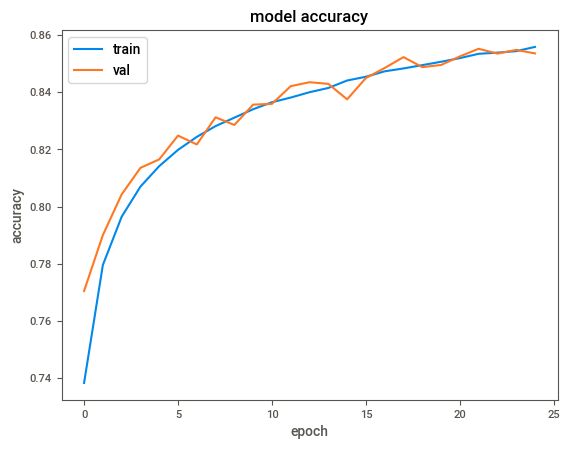

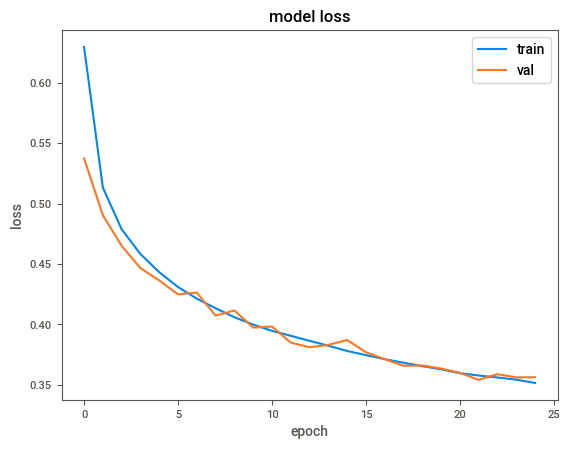

3632/3632 [==============================] - 1s 194us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.88      0.82      0.85     42368
   Lodgepole Pine       0.85      0.91      0.88     56661
   Ponderosa Pine       0.82      0.86      0.84      7151
Cottonwood/Willow       0.79      0.62      0.70       549
            Aspen       0.79      0.44      0.57      1899
      Douglas-fir       0.72      0.59      0.65      3473
        Krummholz       0.90      0.84      0.87      4102

         accuracy                           0.85    116203
        macro avg       0.82      0.72      0.76    116203
     weighted avg       0.85      0.85      0.85    116203



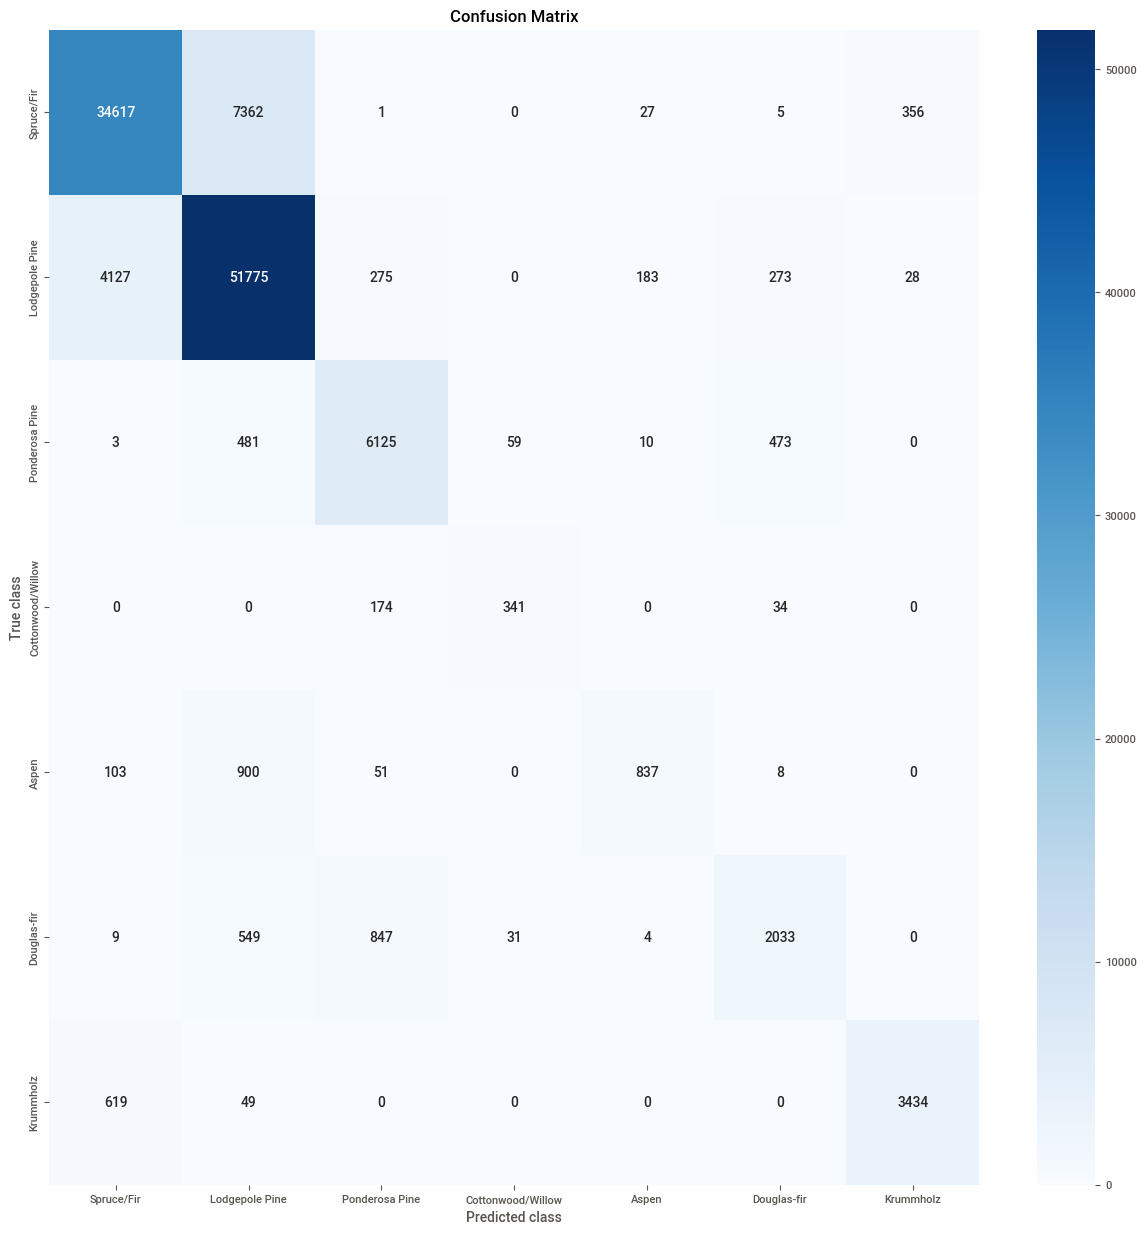

In [133]:
if __name__ == '__main__':
    main()